# Overview

This notebook shows how to define a kernel that is robust to uncalibrated data in the input dimension.

In [2]:
import matplotlib.pyplot as plt

import torch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

In [42]:
def plot_gp(gp, X, y):
    x = torch.linspace(0, 1, 200).reshape(-1,1)
    with torch.no_grad():
        p = gp.posterior(x)

        #get the mean
        m = p.mean

        #get the 2 sigma confidence region around the mean
        l,u = p.mvn.confidence_region()

    plt.figure()

    plt.ylabel('$f$')

    plt.fill_between(x.squeeze(), l[:,1], u[:,1], alpha = 0.25, lw = 0, color='C0')

    plt.scatter(X[:,0][X[:,1]==0], y[X[:,1]==0], color='C1', label='Low-fidelity data')
    plt.scatter(X[:,0][X[:,1]==1], y[X[:,1]==1], color='C0', label='High-fidelity data')
    plt.plot(x, m[:,1], color='C0', lw=1, label='Multi-fidelity GP prediction\n for high-fidelity data')

    plt.legend(loc=0, fontsize='small')
    plt.xlim(0, 1)
    plt.xticks([])
    plt.ylim(-2, 5)

    # Extract correlation coefficient
    cov = gp.task_covar_module._eval_covar_matrix()
    corr = cov[1,0]/torch.sqrt(cov[0,0]*cov[1,1]).item()
    plt.title( f'Correlation coefficient: {corr:.2f}' )

## Robustness to wrong calibration in output

The multifidelity kernel is naturally robust to mismatch between the two fidelities in the output dimension.

In [43]:
# Define synthetic data
# The low-fidelity data is wrongfully calibrated: vertical shift + negative correlation

X1 = torch.tensor([0.03, 0.1, 0.15, 0.17, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
X1 = torch.stack([X1, torch.zeros_like(X1)],dim=-1)
X2 = torch.tensor([0.03, 0.1, 0.14, 0.2, 0.3, 0.97]).to(dtype=torch.float64)
X2 = torch.stack([X2, torch.ones_like(X2)],dim=-1)
X = torch.cat([X1, X2])
y = 0.2*(torch.rand(len(X),1)-0.5) + torch.sin(6*X[:,0:1])*(1-2*X[:,1:]) + 0.6*(1-X[:,1:])

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30b409d50>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30b9aca50>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30b82ba50>
attempt 1
method: L-BFGS-B
options None
x0 None


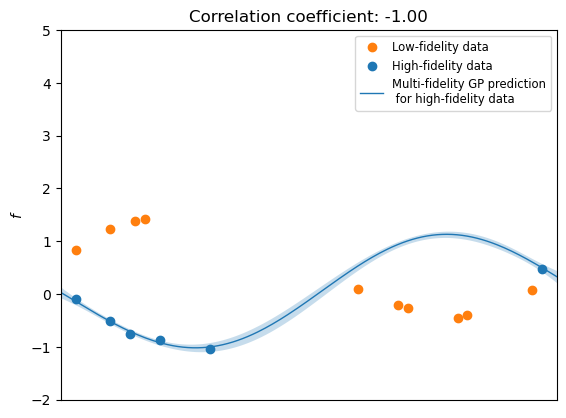

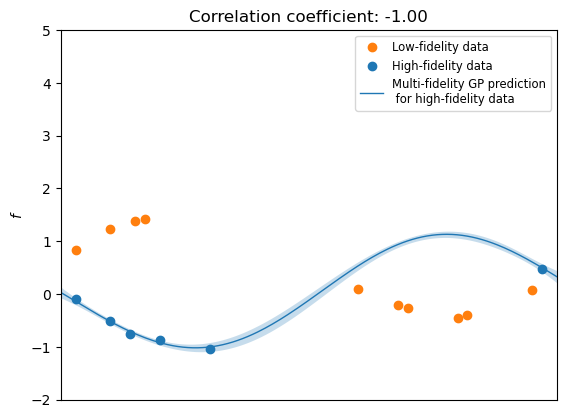

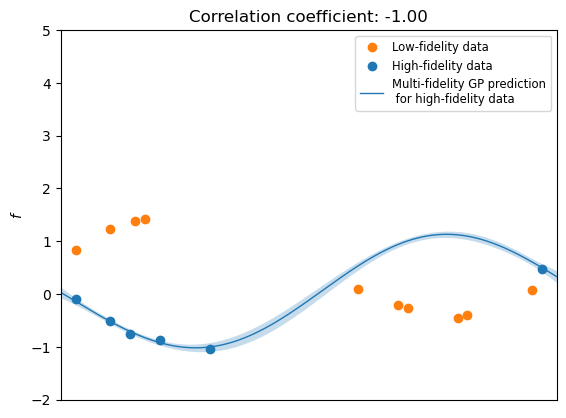

In [44]:
# Train and plot GP (do 3 different training to check for robustness)
for _ in range(3):
    gp = MultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    plot_gp(gp, X, y)


## Non-robustness to wrong calibration in input

In [26]:
# Define synthetic data
# The low-fidelity data is wrongfully calibrated: horizontal shift

X1 = torch.tensor([0.1, 0.15, 0.17, 0.27, 0.3, 0.35, 0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
X1 = torch.stack([X1, torch.zeros_like(X1)],dim=-1)
X2 = torch.tensor([0.03, 0.1, 0.14, 0.2, 0.3, 0.97]).to(dtype=torch.float64)
X2 = torch.stack([X2, torch.ones_like(X2)],dim=-1)
X = torch.cat([X1, X2])
y = 0.2*(torch.rand(len(X),1)-0.5) + torch.sin(6*X[:,0:1]- 1.5*(1-X[:,1:]) )

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30b36a850>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30ba4f1d0>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30bb387d0>
attempt 1
method: L-BFGS-B
options None
x0 None


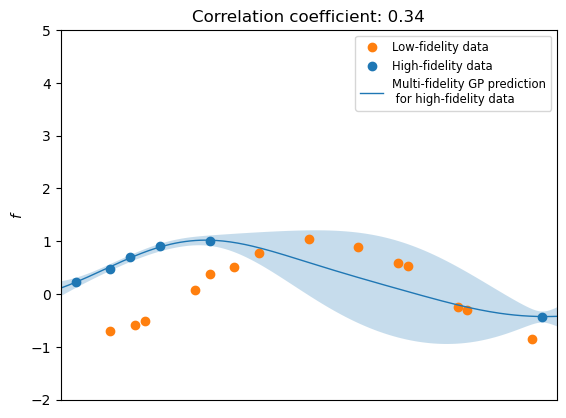

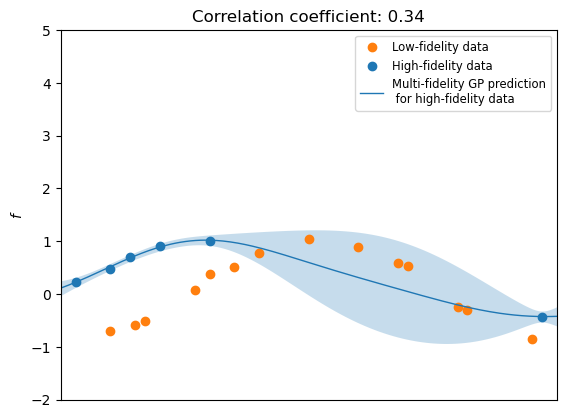

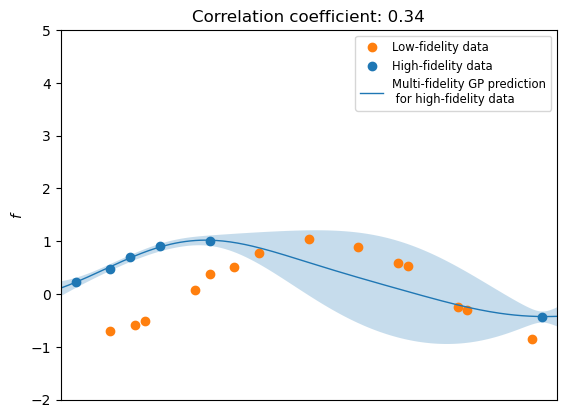

In [31]:
# Train and plot GP (do 3 different training to check for robustness)
for _ in range(3):
    gp = MultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    plot_gp(gp, X, y)


In [32]:
# New hyperparameters; note that the phase has been optimized
for p in gp.named_parameters():
    print(p)
    print('')

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0071], dtype=torch.float64, requires_grad=True))

('mean_module.raw_constant', Parameter containing:
tensor(-0.2886, dtype=torch.float64, requires_grad=True))

('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.2266]], dtype=torch.float64, requires_grad=True))

('task_covar_module.covar_factor', Parameter containing:
tensor([[ 0.4573, -0.7680],
        [ 0.1106, -0.4543]], dtype=torch.float64, requires_grad=True))

('task_covar_module.raw_var', Parameter containing:
tensor([0.0670, 0.0258], dtype=torch.float64, requires_grad=True))



# Define a kernel that is robust to horizontal shift

The idea is to implement a kernel of the form:
$$k[(s, \boldsymbol{x}), (s', \boldsymbol{x'})] = \tilde{\kappa}_{s,s'}\kappa(\boldsymbol{x}-\boldsymbol{x'}-\Delta \boldsymbol{x}_{s, s'})$$

where $\Delta \boldsymbol{x}_{s, s'}$ is a hyperparameter such that:
- $\Delta \boldsymbol{x}_{s, s'} = 0$ if $s=s'$
- $ \Delta \boldsymbol{x}_{s, s'} = - \Delta \boldsymbol{x}_{s', s}$

In [45]:
gp = MultiTaskGP(X, y, task_feature=-1, rank=2)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x30512bd80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x30b31d550>
attempt 1
method: L-BFGS-B
options None
x0 None
